In [140]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
import copy
import time
import sys
import math
from IPython.display import clear_output
np.set_printoptions(threshold=sys.maxsize)
rng = np.random.default_rng()

# Simulate weights in biparental Moran model

In [3]:
def simulate_weights_coupled(p=[0.5], N=1000, n=1000000, idealized=False, Weights="None"):
    """
    Simulates coupled weights for same reproduction events for different values of maternal influence on a child
    (backwards in time). The Model is a biparental Moran model.
    
            Parameters:
                    p (float or list of floats in [0,1]): Portion of individuals weight that goes to mother
                    N (int): Population size
                    n (int): Number of generations to go in past
                    idealized (bool): If True, coupled idealized process (for p=1/N^2) is simulated
                    Weights (list of np_arrays of shape (,N)): Starting weights of population. Can be used to continue 
                    simulating weights when n was chosen to small. Length of Weights has to match length of p + idealized
                    
            Returns:
                    Weights (list of np_arrays of shape (,N)): List of Weights of population n generations in the past for 
                    all values of p
    
    """
    if isinstance(p, float):
        p = [p]
    num_experiments = len(p)
    
    if idealized:
        if Weights == "None":
            Weights = np.ones(shape=(num_experiments+1, N))
            Weights[num_experiments] = Weights[num_experiments]*N
        indices = np.arange(0, N, 1, dtype=int)
        
        print("Simulating weights:")
        clear_output(wait=True)
        
        for i in range(n):
            kappa, pi, mu = rng.choice(indices, size=3, replace=False)
            for j in range(num_experiments):
                Weights[j][pi] = Weights[j][pi] + (p[j])*Weights[j][kappa]
                Weights[j][mu] = Weights[j][mu] + (1-p[j])*Weights[j][kappa]
                Weights[j][kappa] = 0
                
            if Weights[num_experiments][kappa] > Weights[num_experiments][mu]:
                Weights[num_experiments][mu] = Weights[num_experiments][kappa]
            if Weights[num_experiments][kappa] > Weights[num_experiments][pi]:
                Weights[num_experiments][pi] = Weights[num_experiments][kappa]/(N**2)
            Weights[num_experiments][kappa] = 0
            
            if (i % 10000) == 0:
                print("\rSimulating weights: " + str(round((100*i)/n)) + "%")
                clear_output(wait=True)
    else:
        if Weights == "None":
            Weights = np.ones(shape=(num_experiments, N))
        indices = np.arange(0, N, 1, dtype=int)
        
        print("Simulating weights:")
        clear_output(wait=True)
        
        for i in range(n):
            kappa, pi, mu = rng.choice(indices, size=3, replace=False)
            for j in range(num_experiments):
                Weights[j][pi] = Weights[j][pi] + (p[j])*Weights[j][kappa]
                Weights[j][mu] = Weights[j][mu] + (1-p[j])*Weights[j][kappa]
                Weights[j][kappa] = 0
                
            if (i % 10000) == 0:
                print("\rSimulating weights: " + str(round((100*i)/n)) + "%")
                clear_output(wait=True)
                
    print("Simulating weights: 100%")
    clear_output(wait=True)
    
    return Weights

In [4]:
def simulate_weights_fast(p=0.5, N=1000, n=1000000):
    """
    Simulates weights for a biparental moran model. Only faster because progress bar is less accurate.
    """
    Weights = np.ones(N)
    indices = np.arange(0, N, 1, dtype=int)
    print("Simulating weights:")
    clear_output(wait=True)
    for i in range(n):
        kappa, pi, mu = rng.choice(indices, size=3, replace=False)
        Weights[pi] = Weights[pi] + (p)*Weights[kappa]
        Weights[mu] = Weights[mu] + (1-p)*Weights[kappa]
        Weights[kappa] = 0
        if (i % 100000) == 0:
            print("\rSimulating weights: " + str(round((100*i)/n)) + "%")
            clear_output(wait=True)
    print("Simulating weights: 100%")
    clear_output(wait=True)
    return Weights

In [5]:
def adjust_idealized_to_p(Idealized_Weights, p_new, p_old = 1/1000000):
    """
    Is used to turn the idealized process for p=1/N^2 into the idealized process for a new value of p.
    """
    N = len(list(Idealized_Weights))
    Idealized_Weights_new_p = np.zeros(N)
    classes = sort_by_potency_of_p(Idealized_Weights, p_old, no_print = True)
    weight_class = N
    for clas in classes:
        for ind in clas:
            Idealized_Weights_new_p[ind] = weight_class
        weight_class *= p_new
        
    return Idealized_Weights_new_p

In [6]:
def sort_by_potency_of_p_no_log(Weights, p, no_print=False):
    """
    Classifies Weights according to closest potency of p in the absolute sense. Not usefull most of the time.
    """
    N = len(list(Weights))
    Weights.sort()
    classes = []
    indices = np.arange(0, N, 1, dtype=int)
    i = N-1
    current_class = []
    weight_class = N
    counter = 0
    
    while i >= 0:
        
        if Weights[i] == 0:
            break
        
        if abs(Weights[i] - weight_class) <= abs(Weights[i] - (weight_class*p)):
            current_class.append(i)
            i -= 1
            if i < 0:
                classes.append(current_class)
                counter += 1
                if not no_print:
                    print("Größe Klasse " + str(counter) + ": " + str(len(current_class)))
                break
        
        if abs(Weights[i] - weight_class) > abs(Weights[i] - (weight_class*p)):
            classes.append(current_class)
            weight_class *= p
            counter += 1
            if not no_print:
                print("Größe Klasse " + str(counter) + ": " + str(len(current_class)))
            current_class = []
            
    return classes

In [7]:
def sort_by_potency_of_p(Weights, p, no_print=False):
    """
    Classifies weights according to closest potency of p in the log (base N) space.
    
            Parameters:
                    Weights (np_array of shape (,N)): Weights of population
                    p (float in [0,1]): Portion of individuals weight that goes to mother
                    no_print (bool): If False, class_widths are printed
                    
            Returns:
                    classes (list of lists of indices): List of classes. Each class consits of indices of SORTED 
                    individuals that belong to it
    """
    N = len(list(Weights))
    basis_faktor = np.log10(N)
    Weights.sort()
    classes = []
    indices = np.arange(0, N, 1, dtype=int)
    i = N-1
    current_class = []
    weight_class = N
    counter = 0
    
    while i >= 0:
        
        if Weights[i] == 0:
            break
        
        if abs(np.log10(Weights[i]/weight_class)/basis_faktor) <= abs(np.log10(Weights[i]/(weight_class*p))/basis_faktor):
            current_class.append(i)
            i -= 1
            
            if Weights[i] == 0:
                classes.append(current_class)
                counter += 1
                if not no_print:
                    print("Größe Klasse " + str(counter) + ": " + str(len(current_class)))
                break
                
            if i < 0:
                classes.append(current_class)
                counter += 1
                if not no_print:
                    print("Größe Klasse " + str(counter) + ": " + str(len(current_class)))
                break
        
        if abs(np.log10(Weights[i]/weight_class)/basis_faktor) > abs(np.log10(Weights[i]/(weight_class*p))/basis_faktor):
            classes.append(current_class)
            weight_class *= p
            counter += 1
            if not no_print:
                print("Größe Klasse " + str(counter) + ": " + str(len(current_class)))
            current_class = []
            
    return classes

In [8]:
def class_widths_by_p(Weights, p):
    """
    Classifies weights according to closest potency of p in the log (base N) space.
    
            Parameters:
                    Weights (np_array of shape (,N)): Weights of population
                    p (float in [0,1]): Portion of individuals weight that goes to mother
                    
            Returns:
                    class_widths (list of lits of form [str,int]): List of widths of the classes and names. 
                    Classes are ordered from big weights to small weights
    """
    N = len(list(Weights))
    basis_faktor = np.log10(N)
    Weights.sort()
    classes = []
    indices = np.arange(0, N, 1, dtype=int)
    i = N-1
    current_class = []
    weight_class = N
    counter = 0
    class_widths = []
    
    while i >= 0:
        
        if Weights[i] == 0:
            break
        
        if abs(np.log10(Weights[i]/weight_class)/basis_faktor) <= abs(np.log10(Weights[i]/(weight_class*p))/basis_faktor):
            current_class.append(i)
            i -= 1
            
            if Weights[i] == 0:
                classes.append(current_class)
                counter += 1
                class_widths.append(["Klasse " + str(counter), len(current_class)])
                break
                
            if i < 0:
                classes.append(current_class)
                counter += 1
                class_widths.append(["Klasse " + str(counter), len(current_class)])
                break
        
        if abs(np.log10(Weights[i]/weight_class)/basis_faktor) > abs(np.log10(Weights[i]/(weight_class*p))/basis_faktor):
            classes.append(current_class)
            weight_class *= p
            counter += 1
            class_widths.append(["Klasse " + str(counter), len(current_class)])
            current_class = []
            
    return class_widths

### Example

In [9]:
start = time.time()

N = 10000
n = 1000000

indices = np.arange(0, N, 1, dtype=int)
weights = simulate_weights_coupled(N=N, n=n)[0]
weights.sort()

end = time.time()
print(str(round(end-start)) + " Sekunden")

18 Sekunden


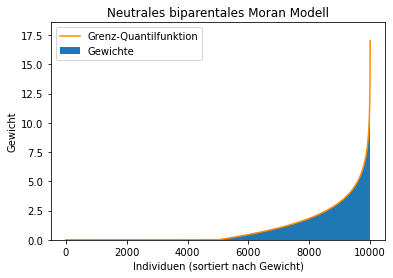

In [13]:
plt.bar(indices, weights, width=1, linewidth=0, edgecolor="black", label="Gewichte")
plt.xlabel("Individuen (sortiert nach Gewicht)")
plt.ylabel("Gewicht")
plt.title("Neutrales biparentales Moran Modell")

ax = plt.gca()
#ax.set_ylim([0, 10])

#This part plots the Quantile function corresponding to the Limit (n,N -> inf) found by Camille Coron & Yves Le Jan
Quantiles = -(2)*np.log(2*(1-indices[int((N*0.5)):]/N))
y = list(np.zeros(int((N*0.5))))
y.extend(Quantiles)
plt.plot(indices, y, color="darkorange", label="Grenz-Quantilfunktion")
plt.legend()

In [14]:
start = time.time()

N = 1000
n = 1000000

indices = np.arange(0, N, 1, dtype=int)
weights_coupled = simulate_weights_coupled(p=[0.5, 1/np.sqrt(N), 1/(N-1), 1/((N-1)*N)], n=n, idealized=True)
weights_coupled.sort()

end = time.time()
print(str(round(end-start)) + " Sekunden")

28 Sekunden


C:\Users\konst\AppData\Local\Temp/ipykernel_10640/2009585573.py:9: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[0]), edgecolors = "tab:blue", facecolors='none', linewidths = 0.5, label = "p=1/2")
C:\Users\konst\AppData\Local\Temp/ipykernel_10640/2009585573.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[1]), edgecolors = "tab:orange", facecolors='none', linewidths = 0.5, label = "p=1/sqrt(N)")
C:\Users\konst\AppData\Local\Temp/ipykernel_10640/2009585573.py:11: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[2]), edgecolors = "tab:olive", facecolors='none', linewidths = 0.5, label = "p=1/N")
C:\Users\konst\AppData\Local\Temp/ipykernel_10640/2009585573.py:12: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[3]), edgecolors = "tab:pink", facecolors='none', linewidths = 0.5, label

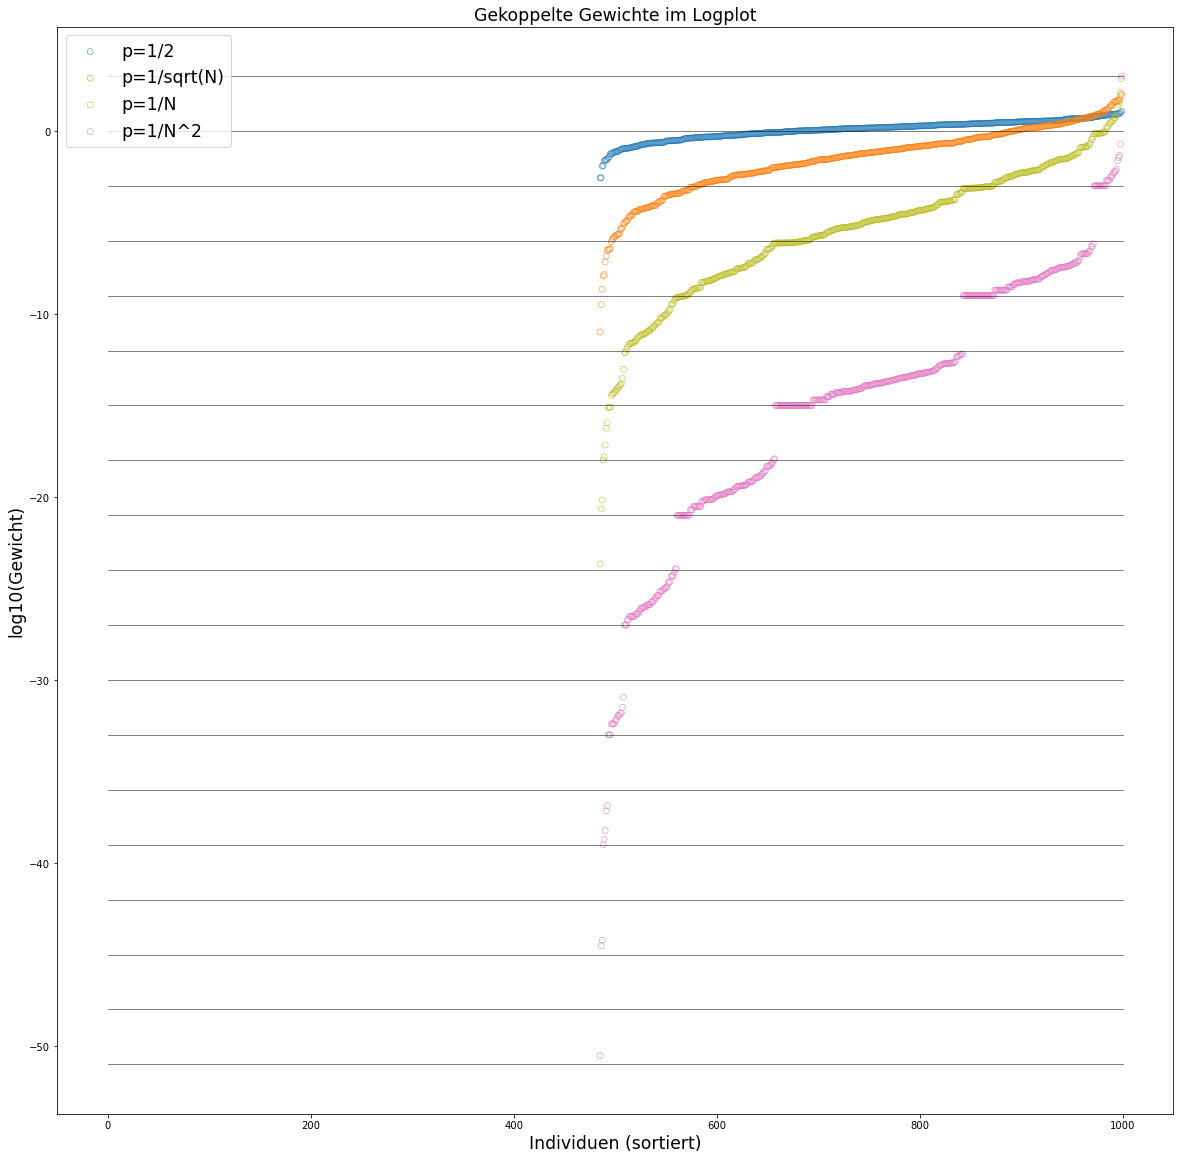

In [39]:
# RuntimeWarning due to approx. half the weights beeing 0
factor = np.log10(N)
first_non_zero = np.where(weights_coupled[0] != 0)[0][0] # Independent of p
low = round(np.log10(weights_coupled[3][first_non_zero]))

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(20, 20)
ax.scatter(indices, np.log10(weights_coupled[0]), edgecolors = "tab:blue", facecolors='none', linewidths = 0.5, label = "p=1/2")
ax.scatter(indices, np.log10(weights_coupled[1]), edgecolors = "tab:orange", facecolors='none', linewidths = 0.5, label = "p=1/sqrt(N)")
ax.scatter(indices, np.log10(weights_coupled[2]), edgecolors = "tab:olive", facecolors='none', linewidths = 0.5, label = "p=1/N")
ax.scatter(indices, np.log10(weights_coupled[3]), edgecolors = "tab:pink", facecolors='none', linewidths = 0.5, label = "p=1/N^2")
for i in range(abs(math.floor(low/factor))+2): # Plots the necessary horizontal lines at potencies of N
    ax.plot([0,N], [-(factor*i)+factor, -(factor*i)+factor], color="black", linewidth=0.5)
plt.xlabel("Individuen (sortiert)", fontsize="xx-large")
plt.ylabel("log10(Gewicht)", fontsize="xx-large")
plt.title("Gekoppelte Gewichte im Logplot", fontsize="xx-large")
plt.legend(fontsize="xx-large", loc='upper left')

C:\Users\konst\AppData\Local\Temp/ipykernel_10640/2117795492.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[3]), edgecolors = "r", facecolors='none', linewidths = 0.5,
C:\Users\konst\AppData\Local\Temp/ipykernel_10640/2117795492.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(ideal), edgecolors = "b", facecolors='none', linewidths = 0.5,


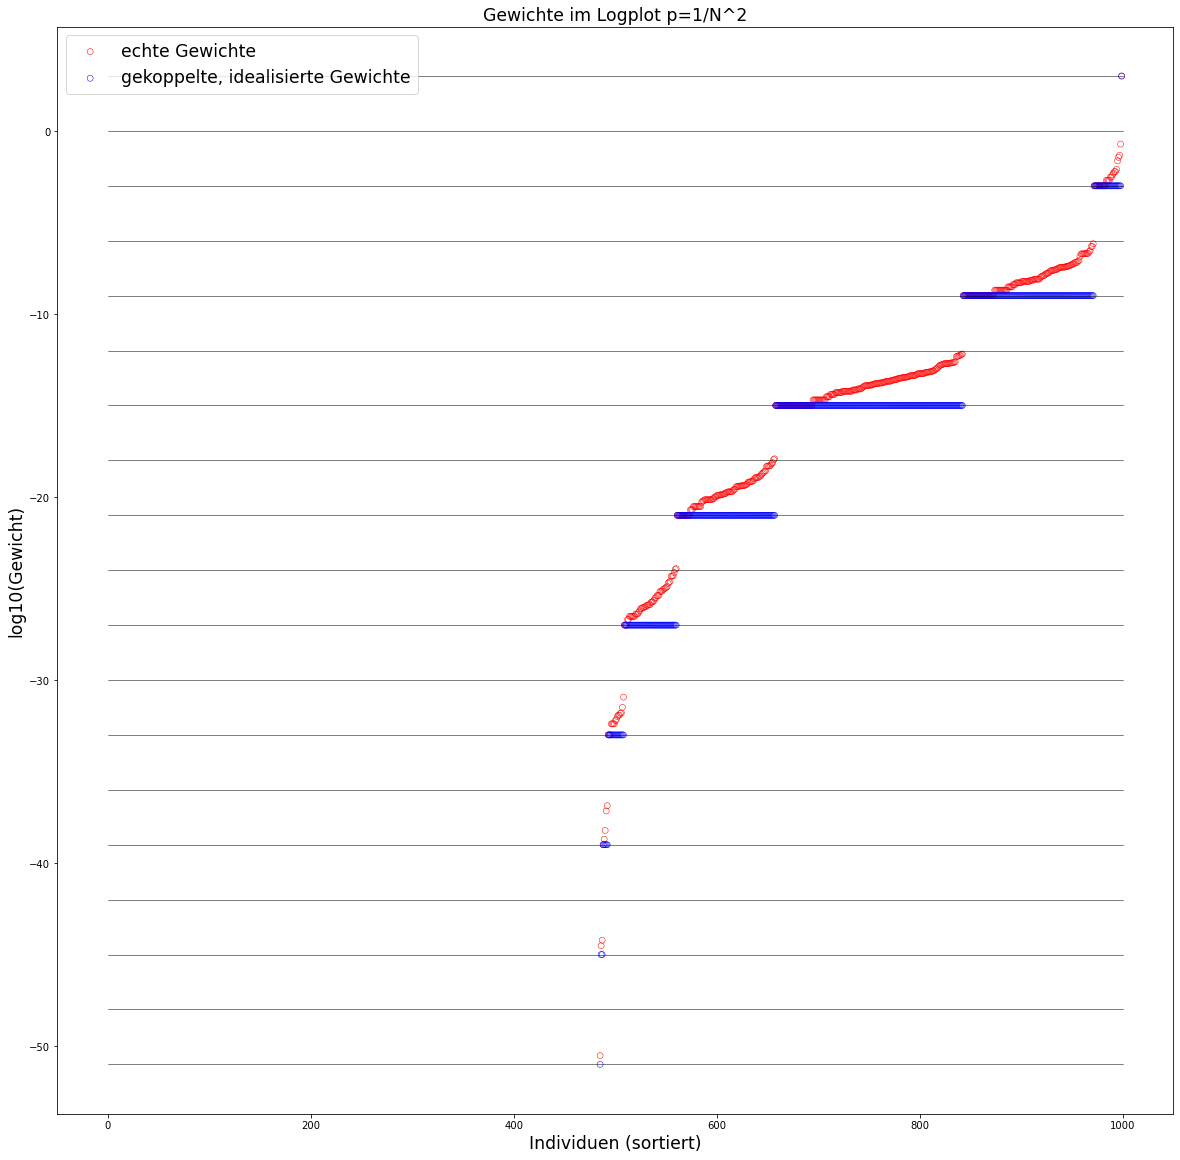

In [37]:
# RuntimeWarning due to approx. half the weights beeing 0
ideal = copy.deepcopy(weights_coupled[4])
low = round(min(np.log10(weights_coupled[3][first_non_zero]), np.log10(ideal[first_non_zero])))

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(20, 20)
ax.scatter(indices, np.log10(weights_coupled[3]), edgecolors = "r", facecolors='none', linewidths = 0.5,
           label = "echte Gewichte")
ax.scatter(indices, np.log10(ideal), edgecolors = "b", facecolors='none', linewidths = 0.5,
           label = "gekoppelte, idealisierte Gewichte")
for i in range(abs(math.floor(low/factor))+2): # Plots the necessary horizontal lines at potencies of N
    ax.plot([0,N], [-(factor*i)+factor, -(factor*i)+factor], color="black", linewidth=0.5)
plt.xlabel("Individuen (sortiert)", fontsize="xx-large")
plt.ylabel("log10(Gewicht)", fontsize="xx-large")
plt.title("Gewichte im Logplot p=1/N^2", fontsize="xx-large")
plt.legend(fontsize="xx-large", loc='upper left')

C:\Users\konst\AppData\Local\Temp/ipykernel_10640/767570590.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[2]), edgecolors = "r", facecolors='none', linewidths = 0.5,
C:\Users\konst\AppData\Local\Temp/ipykernel_10640/767570590.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(ideal), edgecolors = "b", facecolors='none', linewidths = 0.5,


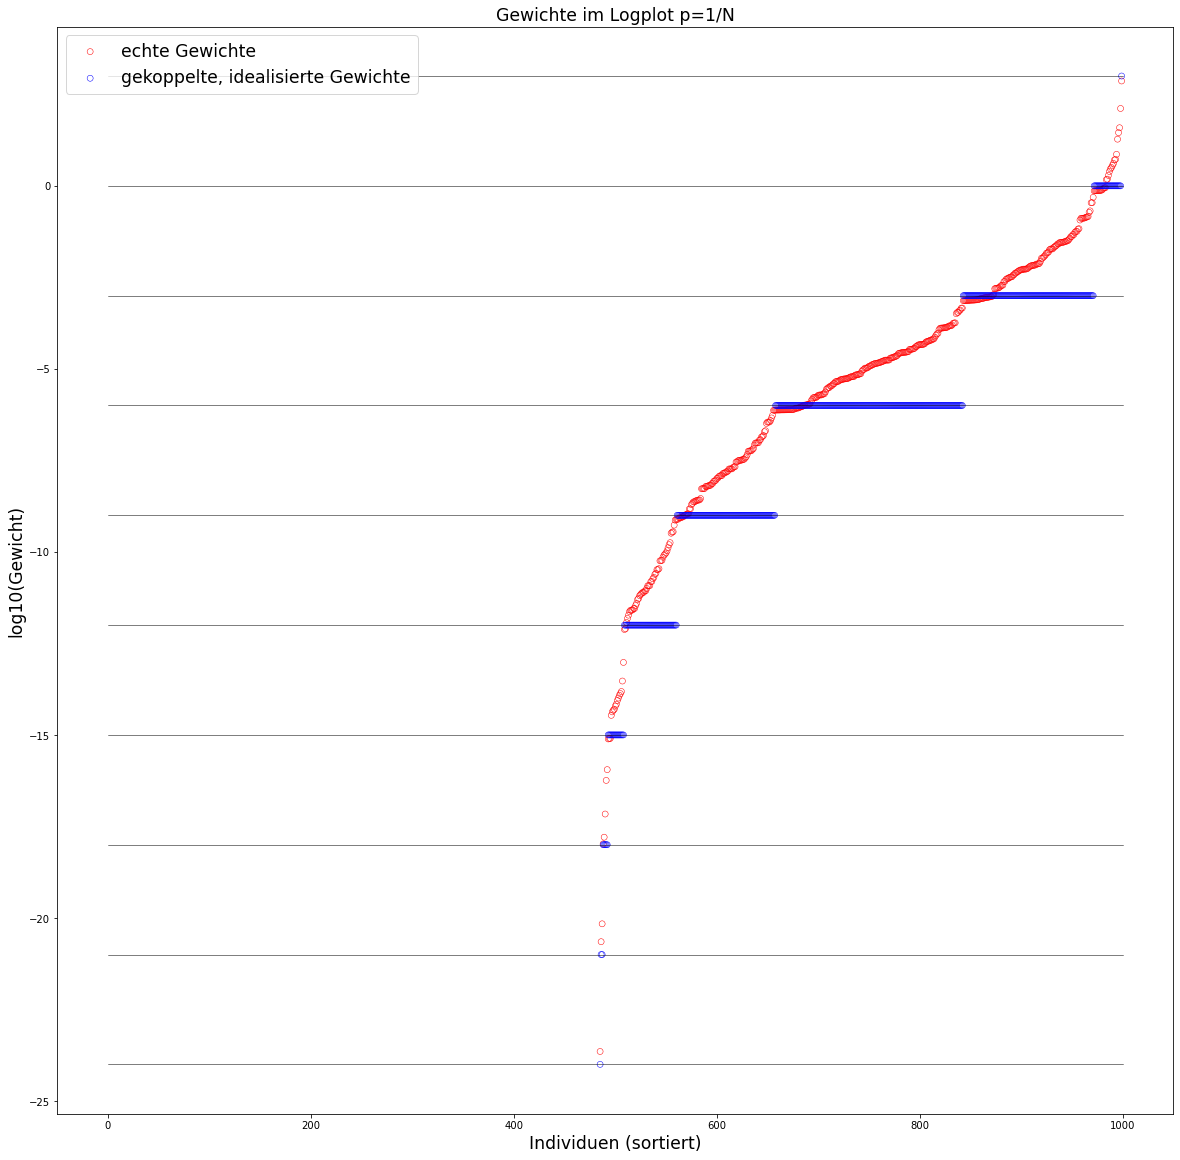

In [40]:
# RuntimeWarning due to approx. half the weights beeing 0
ideal = adjust_idealized_to_p(ideal, p_new=1/N, p_old=1/(N**2))
low = round(min(np.log10(weights_coupled[2][first_non_zero]), np.log10(ideal[first_non_zero])))

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(20, 20)
ax.scatter(indices, np.log10(weights_coupled[2]), edgecolors = "r", facecolors='none', linewidths = 0.5,
           label = "echte Gewichte")
ax.scatter(indices, np.log10(ideal), edgecolors = "b", facecolors='none', linewidths = 0.5,
           label = "gekoppelte, idealisierte Gewichte")
for i in range(abs(math.floor(low/factor))+2): # Plots the necessary horizontal lines at potencies of N
    ax.plot([0,N], [-(factor*i)+factor, -(factor*i)+factor], color="black", linewidth=0.5)
plt.xlabel("Individuen (sortiert)", fontsize="xx-large")
plt.ylabel("log10(Gewicht)", fontsize="xx-large")
plt.title("Gewichte im Logplot p=1/N", fontsize="xx-large")
plt.legend(fontsize="xx-large", loc='upper left')

C:\Users\konst\AppData\Local\Temp/ipykernel_10640/2522802557.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[3]), edgecolors = "r", facecolors='none', linewidths = 0.5,


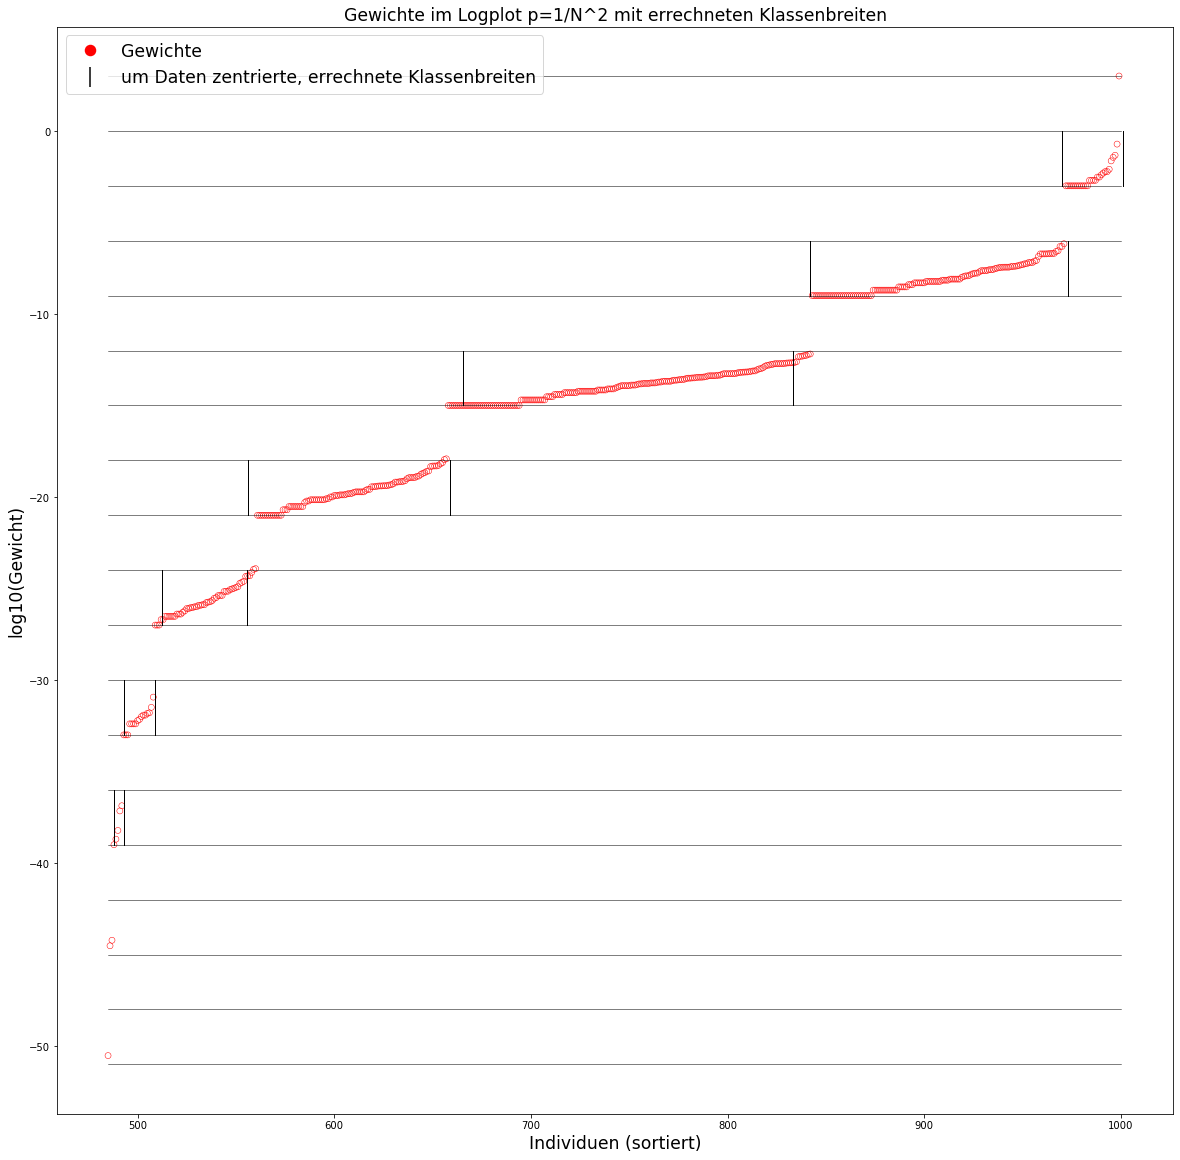

In [160]:
class_widths = np.array(class_widths_by_p(weights_coupled[3], p=1/(N**2)))[:,1].astype(int)
calculated_widths = [1, 30.62, 131.55, 167.75, 102.56, 43.27, 15.67, 5.37]
low = round(np.log10(weights_coupled[3][first_non_zero]))

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(20, 20)
ax.scatter(indices, np.log10(weights_coupled[3]), edgecolors = "r", facecolors='none', linewidths = 0.5,
           label = "Gewichte")

class_sum = 1
for i in range(1, 8): # Has to be a simulation with at least 8 classes
    mid_point = N - class_sum - 0.5*class_widths[i]
    left = mid_point - 0.5*calculated_widths[i]
    right = mid_point + 0.5*calculated_widths[i]
    ax.plot([left, left], [(-2*i+1)*factor, (-2*i+2)*factor], color="black", linewidth=1)
    ax.plot([right, right], [(-2*i+1)*factor, (-2*i+2)*factor], color="black", linewidth=1)
    class_sum += class_widths[i]

for i in range(abs(math.floor(low/factor))+2): # Plots the necessary horizontal lines at potencies of N
    ax.plot([first_non_zero,N], [-(factor*i)+factor, -(factor*i)+factor], color="black", linewidth=0.5)

red_circle = lines.Line2D([], [], color='r', marker='o', linestyle='None', markersize=10, # Just for legend
                          markeredgewidth=1.5, label='Gewichte')
vertical_line = lines.Line2D([], [], color='black', marker='|', linestyle='None', markersize=20, # Just for legend
                             markeredgewidth=1.5, label='um Daten zentrierte, errechnete Klassenbreiten')
plt.xlabel("Individuen (sortiert)", fontsize="xx-large")
plt.ylabel("log10(Gewicht)", fontsize="xx-large")
plt.title("Gewichte im Logplot p=1/N^2 mit errechneten Klassenbreiten", fontsize="xx-large")
plt.legend(handles = [red_circle, vertical_line], fontsize="xx-large", loc='upper left')

C:\Users\konst\AppData\Local\Temp/ipykernel_10640/2883931918.py:7: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[2]), edgecolors = "r", facecolors='none', linewidths = 0.5,


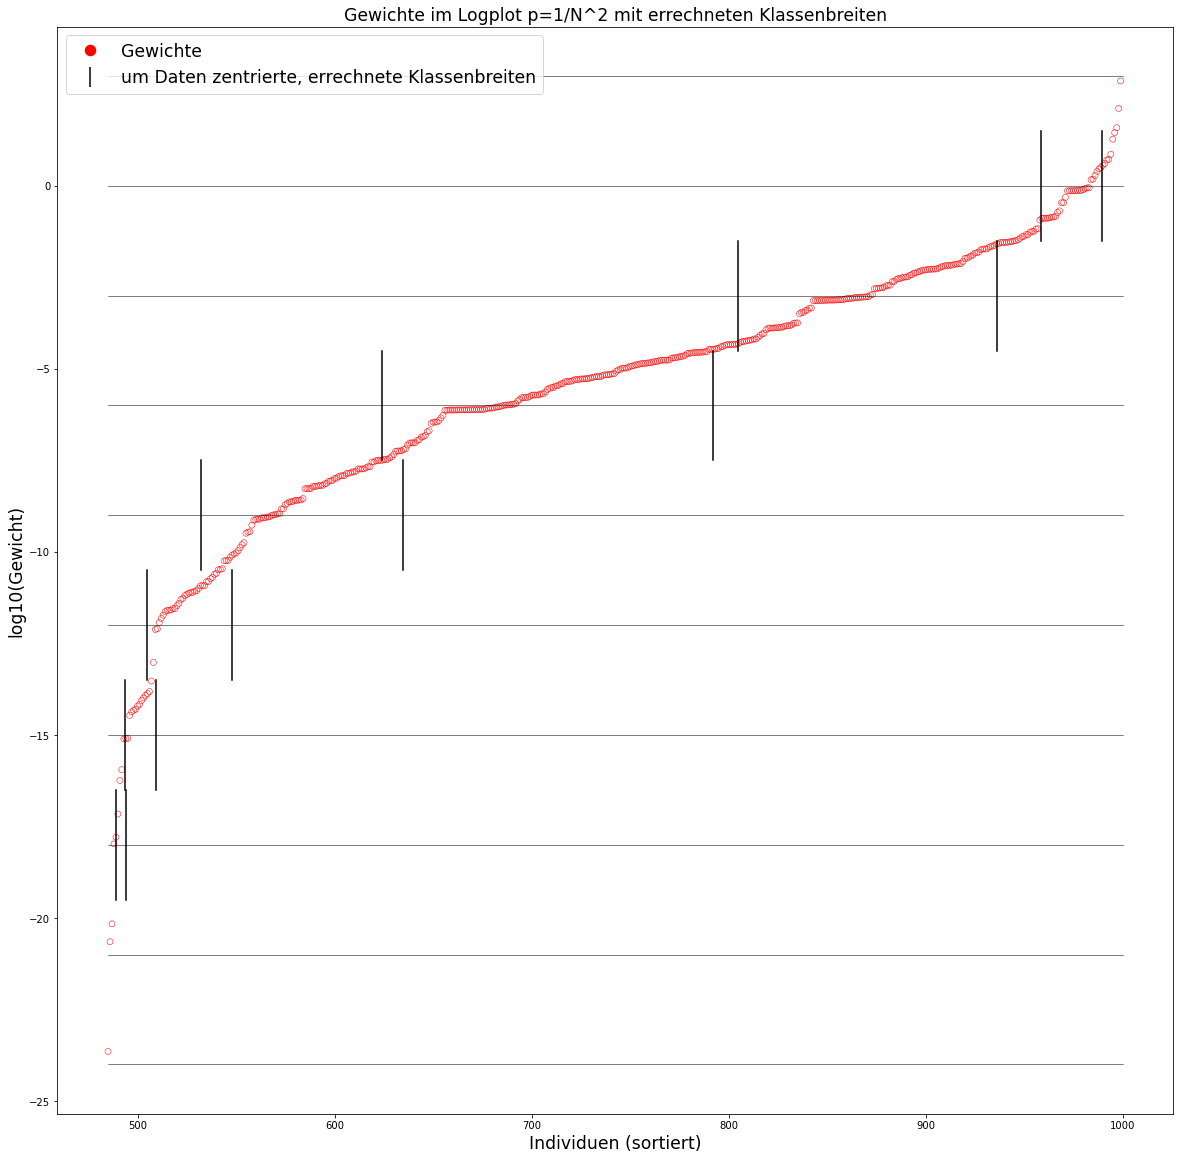

In [161]:
class_widths = np.array(class_widths_by_p(weights_coupled[2], p=1/N))[:,1].astype(int)
low = round(np.log10(weights_coupled[2][first_non_zero]))

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(20, 20)
ax.scatter(indices, np.log10(weights_coupled[2]), edgecolors = "r", facecolors='none', linewidths = 0.5,
           label = "Gewichte")

class_sum = 1
for i in range(1, 8): # Has to be a simulation with at least 8 classes
    mid_point = N - class_sum - 0.5*class_widths[i]
    left = mid_point - 0.5*calculated_widths[i]
    right = mid_point + 0.5*calculated_widths[i]
    ax.plot([left, left], [(-i+0.5)*factor, (-i+1.5)*factor], color="black", linewidth=1.5)
    ax.plot([right, right], [(-i+0.5)*factor, (-i+1.5)*factor], color="black", linewidth=1.5)
    class_sum += class_widths[i]

for i in range(abs(math.floor(low/factor))+2): # Plots the necessary horizontal lines at potencies of N
    ax.plot([first_non_zero,N], [-(factor*i)+factor, -(factor*i)+factor], color="black", linewidth=0.5)

red_circle = lines.Line2D([], [], color='r', marker='o', linestyle='None', markersize=10, # Just for legend
                          markeredgewidth=1.5, label='Gewichte')
vertical_line = lines.Line2D([], [], color='black', marker='|', linestyle='None', markersize=20, # Just for legend
                             markeredgewidth=1.5, label='um Daten zentrierte, errechnete Klassenbreiten')
plt.xlabel("Individuen (sortiert)", fontsize="xx-large")
plt.ylabel("log10(Gewicht)", fontsize="xx-large")
plt.title("Gewichte im Logplot p=1/N^2 mit errechneten Klassenbreiten", fontsize="xx-large")
plt.legend(handles = [red_circle, vertical_line], fontsize="xx-large", loc='upper left')

### Zur Erklärung: Würden die errechneten Klassenbreiten perfekt zu den Daten passen, wären für jeden vertikalen schwarzen Strich nur rote Kreise links unter und recht über seiner Spitze bzw genau umgekehrt.
### Man sieht auch, dass die Klassenteilung jeweils zwischen zwei horizontalen Linien (Potenzen von N im LogN Raum) nicht wirklich zu den Daten passt. Es sieht so aus als könnte man Trennstellen finden, die deutlich besser zu den errechneten Größen passen

In [43]:
# Classes for p=1/N. Note that the class boundaries are chosen somewhat arbitrarily.
classes = sort_by_potency_of_p(weights_coupled[2], 1/N)

Größe Klasse 1: 3
Größe Klasse 2: 50
Größe Klasse 3: 157
Größe Klasse 4: 168
Größe Klasse 5: 81
Größe Klasse 6: 33
Größe Klasse 7: 17
Größe Klasse 8: 3
Größe Klasse 9: 2
Größe Klasse 10: 1


In [42]:
# Classes for p=1/N^2
classes = sort_by_potency_of_p(weights_coupled[3], 1/(N**2))

Größe Klasse 1: 1
Größe Klasse 2: 27
Größe Klasse 3: 129
Größe Klasse 4: 187
Größe Klasse 5: 97
Größe Klasse 6: 50
Größe Klasse 7: 16
Größe Klasse 8: 5
Größe Klasse 9: 2
Größe Klasse 10: 1


In [45]:
# Classes for idealized process with p=1/N^2
classes = sort_by_potency_of_p(weights_coupled[4], 1/(N**2))

Größe Klasse 1: 1
Größe Klasse 2: 27
Größe Klasse 3: 129
Größe Klasse 4: 185
Größe Klasse 5: 97
Größe Klasse 6: 52
Größe Klasse 7: 16
Größe Klasse 8: 5
Größe Klasse 9: 2
Größe Klasse 10: 1


In [163]:
# Calculated class widths of idealized process under assumption that prior classes are of constant size. Cut off after class 11.
1
30.62
131.55
167.75
102.56
43.27
15.67
5.37
1.8
0.6
0.2
print("Sum: 500.39")

Sum: 500.39


In [120]:
start = time.time()

N=1000
n=1000000

class_widths = np.zeros(shape=(20,11))
class_widths_ideal = np.zeros(shape=(20,11))
class_widths_1_over_N = np.zeros(shape=(20,11))

for i in range(20):
    w = simulate_weights_coupled(p=[1/(N-1), 1/(N*(N-1))], N=N, n=n, idealized=True)
    x = np.array(class_widths_by_p(w[1], p=1/(N**2)))[:,1].astype(int)
    y = np.array(class_widths_by_p(w[2], p=1/(N**2)))[:,1].astype(int)
    z = np.array(class_widths_by_p(w[0], p=1/N))[:,1].astype(int)
    while len(x) < 11:
        x = np.append(x, 0)
    while len(y) < 11:
        y = np.append(y, 0)
    while len(z) < 11:
        z = np.append(z, 0)
    if len(x) > 11:
        x = x[:11]
    if len(y) > 11:
        y = y[:11]
    if len(z) > 11:
        z = z[:11]
    class_widths[i,:] = x
    class_widths_ideal[i,:] = y
    class_widths_1_over_N[i,:] = z
    
mean_class_widths = np.mean(class_widths, axis=0)
mean_class_widths_ideal = np.mean(class_widths_ideal, axis=0)
mean_class_widths_1_over_N = np.mean(class_widths_1_over_N, axis=0)

end = time.time()
print(str(round(end-start)/60) + " Minuten")

7.716666666666667 Minuten


In [121]:
mean_class_widths

array([1.300e+00, 3.330e+01, 1.302e+02, 1.626e+02, 1.040e+02, 4.530e+01,
       1.600e+01, 4.950e+00, 1.700e+00, 5.500e-01, 5.000e-02])

In [122]:
mean_class_widths_ideal

array([1.3000e+00, 3.3050e+01, 1.2965e+02, 1.6255e+02, 1.0440e+02,
       4.5600e+01, 1.6150e+01, 4.9500e+00, 1.7000e+00, 5.5000e-01,
       5.0000e-02])

In [123]:
mean_class_widths_1_over_N

array([3.300e+00, 5.525e+01, 1.552e+02, 1.522e+02, 8.310e+01, 3.345e+01,
       1.235e+01, 3.400e+00, 1.300e+00, 4.000e-01, 1.000e-01])

### Time costly example

In [ ]:
start = time.time()

N = 10000
n = 100000000

weights_2 = np.ones(shape=(3,N))
ind = np.arange(0, N, 1, dtype=int)
class_widths = []
class_widths_ideal = []
class_widths_1_over_N = []

factor = np.log10(N)

for j in range(1, 6): # 5*n Generations in total with plots every n generations
    weights_2 = simulate_weights_coupled(p=[1/(N*(N-1)), 1/(N-1)], N=N, n=n, idealized=True, Weights=weights_2)
    ideal = copy.deepcopy(weights_2[2])
    ideal.sort()
    ideal_one_over_N = adjust_idealized_to_p(ideal, p_new=1/N, p_old=1/(N**2))
    ideal_one_over_N.sort()
    weights_2[0].sort()
    weights_2[1].sort()
    weights_2[2].sort()
    first_non_zero = np.where(weights_2[0] != 0)[0][0]
    lowest_0 = round(min(np.log10(weights_2[0][first_non_zero]), np.log10(ideal[first_non_zero])))
    lowest_1 = round(min(np.log10(weights_2[1][first_non_zero]), np.log10(ideal_one_over_N[first_non_zero])))
    
    class_widths.append(class_widths_by_p(weights_2[0], p=1/(N**2)))
    class_widths_ideal.append(class_widths_by_p(ideal, p=1/(N**2)))
    class_widths_1_over_N.append(class_widths_by_p(weights_2[1], p=1/N))
    
    # Plot for p=1/N^2
    ax = plt.gca()
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax.scatter(ind, np.log10(weights_2[0]), edgecolors = "r", facecolors='none', linewidths = 0.5, label = "echte Gewichte")
    ax.scatter(ind, np.log10(ideal), edgecolors = "b", facecolors='none', linewidths = 0.5,
               label = "gekoppelte, idealisierte Gewichte")
    for i in range(abs(math.floor(lowest_0/factor))+2): # Plots the necessary horizontal lines at potencies of N
        ax.plot([0,N], [-(factor*i)+factor, -(factor*i)+factor], color="black", linewidth=0.5)
    plt.xlabel("Individuen (sortiert)", fontsize="xx-large")
    plt.ylabel("log10(Gewicht)", fontsize="xx-large")
    plt.title("Gewichte im Logplot p=1/N^2", fontsize="xx-large")
    plt.legend(fontsize="xx-large")
    fig.savefig("Log_Weights_N=10000_n=" + str(j*n) + ".png")
    fig.clear()
    
    # Plot for p=1/N
    ax = plt.gca()
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax.scatter(ind, np.log10(weights_2[1]), edgecolors = "r", facecolors='none', linewidths = 0.5, label = "echte Gewichte")
    ax.scatter(ind, np.log10(ideal_one_over_N), edgecolors = "b", facecolors='none', linewidths = 0.5,
               label = "gekoppelte, idealisierte Gewichte")
    for i in range(abs(math.floor(lowest_1/factor))+2):
        ax.plot([0,N], [-(factor*i)+factor, -(factor*i)+factor], color="black", linewidth=0.5)
    plt.xlabel("Individuen (sortiert)", fontsize="xx-large")
    plt.ylabel("log10(Gewicht)", fontsize="xx-large")
    plt.title("Gewichte im Logplot p=1/N", fontsize="xx-large")
    plt.legend(fontsize="xx-large")
    fig.savefig("Log_Weights_1_over_N_N=10000_n=" + str(j*n) + ".png")
    fig.clear()
    
#text_file = open("Klassenbreiten.txt", "w")
#text_file.write(str(class_widths) + " "*500 + str(class_widths_ideal) + " "*500 + 
#                str(class_widths_1_over_N) + " "*500 + str(class_widths_1_over_N_ideal))
#text_file.close()

end = time.time()
print(str(round(end-start)/3600) + " Stunden")

# Momentevergleich für festes p

In [46]:
def compute_first_k_moments(k, p):
    """
    Computes first k moments of limiting distribution of a weight (N,n -> inf) according to limit found heuristically.
    """
    moments = [-1]
    if k == 1:
        return np.array([1])
    for m in range(2, k+1):
        m_moment = 0
        for i in range(1,m):
            m_moment += (p**i + (1-p)**i)*moments[i-1]*moments[m-i-1]
        m_moment = m_moment / (1-p**m-(1-p)**m)
        moments.append(m_moment)
    return np.array(moments)*np.array([np.math.factorial(i)*(-1)**i for i in range(1,k+1)])

In [47]:
def estimate_first_k_moments(k, p, N=10000, n=1000000):
    """
    Estimates first k moments of simulated weights according to the standard moment method. These estimators 
    are unfortunately biased. Unbiased estimators could be computed for the centered moments.
    """
    est_moments = np.zeros(k)
    Weights = np.ones(N)
    indices= np.arange(0, N, 1, dtype=int)
    print("Simulating weights:")
    clear_output(wait=True)
    for i in range(n):
        kappa, pi, mu = rng.choice(indices, size=3, replace=False)
        Weights[pi] = Weights[pi] + (p)*Weights[kappa]
        Weights[mu] = Weights[mu] + (1-p)*Weights[kappa]
        Weights[kappa]=0
        if (i % 10000) == 0:
            print("\rSimulating weights: " + str(round((100*i)/n)) + "%")
            clear_output(wait=True)
    print("Simulating weights: 100%")
    clear_output(wait=True)
    weights = copy.deepcopy(Weights)
    for i in range(0, k):
        est_moments[i] = np.mean(weights)
        weights *= Weights
    return est_moments

### Example

In [48]:
# Computed moments of heuristically found limit for p=0.5
compute_first_k_moments(k=5, p=0.5)

array([1.00e+00, 4.00e+00, 2.40e+01, 1.92e+02, 1.92e+03])

In [49]:
# Moments of prooven limit found by Camille Coron & Yves Le Jan
moments = []
for i in range(1, 6):
    moments.append(2**(i-1)*np.math.factorial(i))
moments

[1, 4, 24, 192, 1920]

### Example for p=0.25

In [51]:
start = time.time()

moments_independent_sim = []
for i in range(15):
    moments_independent_sim.append(list(estimate_first_k_moments(8, 0.25, N=50000, n=1000000)))

moments_independent_sim = np.array(moments_independent_sim)    
#text_file = open("estimated_moments_p=0,25.txt", "w")
#text_file.write(np.array2string(moments_independent_sim))
#text_file.close()

means_of_moments = np.mean(moments_independent_sim, axis=0)
standard_errors = np.std(moments_independent_sim, axis=0) / np.sqrt(15)

end = time.time()
print(str(round(end-start)/60) + " Minuten")

4.1 Minuten


In [50]:
compute_first_k_moments(k=8, p=0.25)

array([1.00000000e+00, 5.33333333e+00, 4.62222222e+01, 5.47964240e+02,
       8.18764070e+03, 1.47200126e+05, 3.09014648e+06, 7.41587950e+07])

In [52]:
means_of_moments

array([1.00000000e+00, 5.33628151e+00, 4.61964146e+01, 5.44867625e+02,
       8.07307168e+03, 1.44298634e+05, 3.04963555e+06, 7.52251836e+07])

In [54]:
standard_errors

array([2.34055565e-17, 8.90760638e-03, 2.24197830e-01, 7.00082959e+00,
       2.53621359e+02, 9.82610985e+03, 3.92893386e+05, 1.59525467e+07])

# Maternal lines

In [ ]:
def trace_interesting_lines(p, N=1000, n=10000000, tracked_parental_lines=5, tracked_extreme_weights=10):
    """
    Traces weights of maternal, paternal and mixed lineages as well as maximal and minimal weights backwards in time.
    
            Parameters:
                    p (float in [0,1]): Portion of individuals weight that goes to mother
                    N (int): Population size
                    n (int): Number of generations to go in past
                    tracked_parental_lines (int): Number of the first maternal/paternal lines of which weights are tracked.
                    A low number should be enough since they coaless. Scales poorly in complexity and space
                    tracked_extreme_weights (int): Number of the biggest and smallest weightsthat are tracked
                    
            Returns:
                    List of:
                            Weights (list of floats, shape=(,N)): Weights of population n generations in the past
                            max_weights (list of lists, shape=(tracked_extreme_weights,n/100)): Biggest weights over all n 
                            generations in steps of 100 generations
                            min_weights (list of lists, shape=(tracked_extreme_weights,n/100)): Smallest weights over all n 
                            generations in steps of 100 generations
                            motherlines_weights (list of lists, shape=(tracked_parental_lines,n/100)): Weights of the tracked
                            maternal lines over all n generations in steps of 100 generations
                            fatherlines_weights (list of lists, shape=(tracked_parental_lines,n/100)): Weights of the tracked
                            paternal lines over all n generations in steps of 100 generations
                            coalece_mother (int): Coalescence time of all N maternal lines (up to 99 larger than in actuality)
                            coalece_father (int): Coalescence time of all N paternal lines (up to 99 larger than in actuality)
                            father_mother_weight (list of floats, shape=(,n/100)): Weight of a mixed maternal and paternal line 
                            starting from Individual 0 over all n generations
    """
    Weights = np.ones(N)
    indices = np.arange(0, N, 1, dtype=int)
    max_weights = [[] for i in range(tracked_extreme_weights)]
    min_weights = [[] for i in range(tracked_extreme_weights)]
    motherlines_weights = [[1.0] for i in range(tracked_lines)]
    indi_motherlines = list(np.arange(0, N, 1, dtype=int))
    fatherlines_weights = [[1.0] for i in range(tracked_lines)]
    indi_fatherlines = list(np.arange(0, N, 1, dtype=int))
    father_mother_weight = [1.0]
    indi_father_mother = 0
    coalece_mother = 0
    coalece_father = 0
    print("Simulating weights:")
    clear_output(wait=True)
    for i in range(n):
        kappa, pi, mu = rng.choice(indices, size=3, replace=False)
        Weights[pi] = Weights[pi] + (p)*Weights[kappa]
        Weights[mu] = Weights[mu] + (1-p)*Weights[kappa]
        Weights[kappa] = 0
        indi_motherlines = [mu if x == kappa else x for x in indi_motherlines]
        indi_fatherlines = [pi if x == kappa else x for x in indi_fatherlines]
        if kappa == indi_father_mother:
            if (i % 2) == 0:
                indi_father_mother = mu
            else:
                indi_father_mother = pi
        if (i % 100) == 99:
            w = copy.deepcopy(Weights)
            w.sort()
            w_not_0 = np.where(w != 0)[0]
            for m in range(tracked_extreme_weights):
                max_weights[m].append(w[-(m+1)])
                min_weights[m].append(w[w_not_0[m]]) 
            for l in range(tracked_lines):
                motherlines_weights[l].append(Weights[indi_motherlines[l]])
                fatherlines_weights[l].append(Weights[indi_fatherlines[l]])
            if coalece_mother == 0:
                if min(indi_motherlines) == max(indi_motherlines):
                    coalece_mother = i
            if coalece_father == 0:
                if min(indi_fatherlines) == max(indi_fatherlines):
                    coalece_father = i
            father_mother_weight.append(Weights[indi_father_mother])
        if (i % 10000) == 0:
            print("\rSimulating weights: " + str(round((100*i)/n)) + "%")
            clear_output(wait=True)
    print("Simulating weights: 100%")
    clear_output(wait=True)
    return [list(Weights), max_weights, min_weights,  motherlines_weights, fatherlines_weights,
            coalece_mother, coalece_father, father_mother_weight]

### Example
##### In Bacterial_Ancestry_Raw under "Motherlines new". A lot of saved plots that i can share.

# Biparental Moran with two children

In [24]:
def simulate_weights_moran_2_children(N, n):
    """
    Simulates weights of neutral biparental Moran model with two children backwards in time.
    """
    Weights = np.ones(N)
    indices= np.arange(0, N, 1, dtype=int)
    for i in range(n):
        kappa, delta, pi, mu = rng.choice(indices, size=4, replace=False)
        Weights[pi] = Weights[pi] + (1/2)*Weights[kappa] + (1/2)*Weights[delta]
        Weights[mu] = Weights[mu] + (1/2)*Weights[kappa] + (1/2)*Weights[delta]
        Weights[kappa]=0
        Weights[delta]=0
    return Weights

### Example

In [27]:
start = time.time()

N = 10000
n = 10000000

indices = np.arange(0, N, 1, dtype=int)
weights_2children = simulate_weights_moran_2_children(N, n)
weights_2children.sort()

end = time.time()
print(str(round(end-start)) + " Sekunden")

160 Sekunden


(0.0, 15.0)

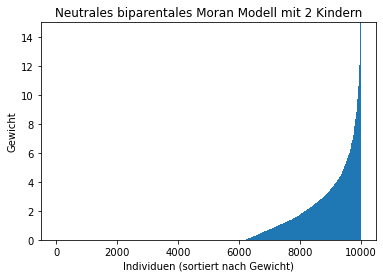

In [41]:
plt.bar(indices, weights_2children, width=1, linewidth=0, edgecolor="black")
plt.xlabel("Individuen (sortiert nach Gewicht)")
plt.ylabel("Gewicht")
plt.title("Neutrales biparentales Moran Modell mit 2 Kindern")

ax = plt.gca()
ax.set_ylim([0, 15])

# Biparental Wright-Fisher

In [11]:
def simulate_weights_wright_fisher(N, n):
    """
    Simulates weights of neutral biparental Wright-Fisher model backwards in time. Double Loop makes it slow.
    """
    Weights = np.ones(N)
    indices= np.arange(0, N, 1, dtype=int)
    for i in range(n):
        np.random.shuffle(indices)
        parents = np.random.randint(0, N/2, size=(N))
        w = np.zeros(N)
        counter = 0
        for j in parents:
            w[indices[2*j]] += 0.5*Weights[counter]
            w[indices[2*j+1]] += 0.5*Weights[counter]
            counter += 1
        Weights = w
    return Weights

# 5-parental Moran

In [9]:
def simulate_weights_moran_5_parents(N, n):
    """
    Simulates weights of neutral 5-parental Moran model backwards in time. rng.shuffle scales much wors in N than rng.choice.
    """
    Weights = np.ones(N)
    indices= np.arange(0, N, 1, dtype=int)
    for i in range(n):
        rng.shuffle(indices)
        kappa=indices[0]
        pi=indices[1]
        mu=indices[2]
        alpha=indices[3]
        beta=indices[4]
        delta=indices[5]
        Weights[pi] = Weights[pi] + 0.2*Weights[kappa]
        Weights[mu] = Weights[mu] + 0.2*Weights[kappa]
        Weights[alpha] = Weights[alpha] + 0.2*Weights[kappa]
        Weights[beta] = Weights[beta] + 0.2*Weights[kappa]
        Weights[delta] = Weights[delta] + 0.2*Weights[kappa]
        Weights[kappa]=0
    return Weights

### Example

In [29]:
start = time.time()

N = 1000
n = 10000

indices = np.arange(0, N, 1, dtype=int)
weights_wf = simulate_weights_wright_fisher(N, n)
weights_m5 = simulate_weights_moran_5_parents(N, n)
weights_wf.sort()
weights_m5.sort()

end = time.time()
print(str(round(end-start)) + " Sekunden")

17 Sekunden


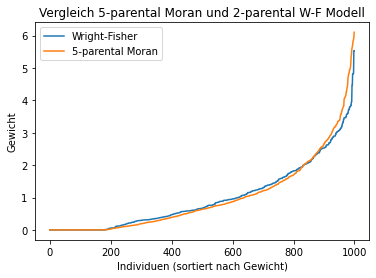

In [30]:
plt.plot(indices, weights_wf, label = "Wright-Fisher")
plt.plot(indices, weights_m5, label = "5-parental Moran")
plt.xlabel("Individuen (sortiert nach Gewicht)")
plt.ylabel("Gewicht")
plt.title("Vergleich 5-parental Moran und 2-parental W-F Modell")
plt.legend()

# Moran with sexes

In [43]:
def simulate_weights_moran_with_sexes(N, n):
    """
    Simulates weights of neutral Moran model with sexes backwards in time. N is half the population size.
    """
    Weights_male = np.ones(N)
    Weights_female = np.ones(N)
    indices_male = np.arange(0, N, 1, dtype=int)
    indices_female = np.arange(0, N, 1, dtype=int)
    for i in range(n):
        pi, kappa_male = rng.choice(indices_male, size=2, replace=False)
        mu, kappa_female = rng.choice(indices_female, size=2, replace=False)
        kappa_gender = np.random.randint(2)
        if kappa_gender == 0:
            Weights_male[pi] = Weights_male[pi] + (1/2)*Weights_male[kappa_male]
            Weights_female[mu] = Weights_female[mu] + (1/2)*Weights_male[kappa_male]
            Weights_male[kappa_male]=0
        if kappa_gender == 1:
            Weights_male[pi] = Weights_male[pi] + (1/2)*Weights_female[kappa_female]
            Weights_female[mu] = Weights_female[mu] + (1/2)*Weights_female[kappa_female]
            Weights_female[kappa_female]=0
    return np.append(Weights_male, Weights_female)

### Example

In [44]:
start = time.time()

N = 1000
n = 100000

indices = np.arange(0, 2*N, 1, dtype=int)
weights_sexes = simulate_weights_moran_with_sexes(N, n)
weights_sexes.sort()

end = time.time()
print(str(round(end-start)) + " Sekunden")

3 Sekunden


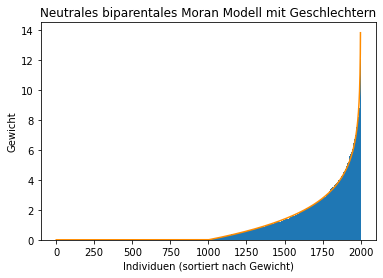

In [45]:
plt.bar(indices, weights_sexes, width=1, linewidth=0, edgecolor="black")
plt.xlabel("Individuen (sortiert nach Gewicht)")
plt.ylabel("Gewicht")
plt.title("Neutrales biparentales Moran Modell mit Geschlechtern")

Quantiles = -(2)*np.log(2*(1-indices[int((N)):]/(2*N)))
y = list(np.zeros(int((N))))
y.extend(Quantiles)
plt.plot(indices, y, color="darkorange")